# Predicting Federal Funds Rate Changes
    Xander de la Bruere
    Jakob Gertsch
    Sam Layton
    Matt Mella
    Wilson Stoddard

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta
import fredapi as fd
from prince import FAMD
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from prince import FAMD
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt


### Research Question Overview

One of the most important and influential indicators of the United States economy is the federal funds rate, often colloquially referred to as the interest rate. The federal funds rate (FFR) is a target interest rate set by the Federal Reserve (Fed) in an attempt to control other key economic indicators. The Fed seeks to reach its target interest rate by setting a discount rate (the cost banks face to borrow money from other banks in order to meet overnight reserve requirements), engaging in open market operations (reducing or increasing the quantity of U.S. treasury bills available for purchase), and adjusting reserve requirement (the percentage of money banks must keep in reserve rather than lending it to clients) (#1). In practice, the federal funds rate truly does prevail as the standard interest rate throughout the economy.

The Fed is tasked with promoting "maximum employment, stable prices, and moderate long-term interest rates" (#2). Although this list contains three goals, it is commonly referred to as the "dual mandate", as it is often summarized as aiming for maximum employment and low, stable inflation (#2). An increase or decrease in the FFR impacts levels of personal consumption and spending as well as corporate investment, which affects inflation. Higher interest rates increase the cost of borrowing money, which allows us to think of interest rates as the price of money. For example, when interest rates are relatively high, consumers have greater incentive to save money (and earn interest) rather than spending, while companies have less incentive to invest (since they must borrow at a higher rate to do so). This leads to an overall cooling in the economy. Conversely, lower interest rates increase personal consumption and corporate investment, which stimulates the economy. Together, these personal and corporate decisions, all based on the federal funds rate, have direct and dramatic effects on important economic indicators such as inflation, real GDP, mortgage rates, and unemployment. 

Since the interest rate influences so many economic outcomes, foreknowledge of changes in the FFR would allow consumers, producers, and investment managers to time and allocate their resources effectively. Of particular interest to our group is how changes in the FFR affect the performance of institutional investors' bond portfolios. There is an inverse relationship between interest rates and bond prices; higher interest rates lead to lower prices (#3). Thus, bond portfolios can get burned by a rapid increase in rates, leading to a painful dip in returns (#3). Even equity portfolios can be negatively impacted by higher rates. As companies have less incentive to borrow money for spending on new projects, the higher rates often lead to lower profits, and thus lower stock prices. For this reason, much effort is expended to predict the target FFR, which is determined roughly every six weeks by the Federal Open Market Committee (FOMC), the policy-making team of the Federal Reserve (#4). The FOMC has shared some indicators that it considers in its decisions, including various price indices and labor market indicators, such as the annual change in the price index for personal consumption expenditures (#5). However, it does not explicitly share the way it considers or weights these metrics.

Many predictive bodies, such as the Blue Chip consensus, are relatively successful at predicting changes in the FFR when most or all economic indicators are positive (or negative), but are inconsistent in accuracy when economic conditions are mixed (#6). Their historical accuracy and prediction methods are unclear. As a proxy for their accuracy, we use as a benchmark for the success of our methods as the naive method of predicting that each meeting, the Fed will choose to hold interest rates constant. Using the techniques of regression and classification, we seek to appropriately select critical features from available economic indicators in order to develop a robust model for predicting changes in the FFR. In particular, we are concerned with finding features that best predict FOMC decisions to raise, lower, or hold constant the target FFR. Throughout this project, we seek to answer three key questions: 1) What features have the most predictive power for forecasting FOMC decisions? 2) What regression and classification methods are best suited to forecasting these decisions? 3) How accurately can we predict FOMC decisions?

Citations:
1. https://www.federalreserve.gov/monetarypolicy/fomc.htm
2. https://www.federalreserve.gov/monetarypolicy/monetary-policy-what-are-its-goals-how-does-it-work.htm
3. https://www.morningstar.com/portfolios/how-invest-your-money-fed-raises-interest-rates
4. https://www.investopedia.com/terms/f/federalfundsrate.asp
5. https://federalreserve.gov/monetarypolicy/monetary-policy-what-are-its-goals-how-does-it-work.htm
6. https://www.stlouisfed.org/publications/regional-economist/july-2000/inside-the-briefcase-the-art-of-predicting-the-federal-reserve

### Our Data

In our search for data on key economic indicators that might influence the FFR, we looked to the St. Louis Federal Reserve (FRED) website (#1). This site hosts an enormous quantity of time series data on economic indicators. This data has been carefully and methodically tracked, and is a gold standard for economic data. Many reputable news sources, including the Wall Street Journal, frequently cite FRED data. In selecting features, we focused on features with data continuously tracked since 1989 (the year our FOMC decisions data starts) to the present day. We also chose features that we felt were most likely to have predictive power in determining the FOMC's decision to raise or lower interest rate. With these two considerations in mind, we selected the several features which are summarized in the table below.

| Feature | Variable | Frequency | Description |
| --- | --- | --- | --- |
| Bank Prime Loan Rate Changes | `loan` | daily | Rate charged by banks for short-term loans to creditworthy debtors |
| Exports of Goods and Services | `export` | quarterly | Total dollar value of goods and services exported in the quarter |
| Personal Consumption Expenditures Rate | `pce` | monthly | Measure of core inflation for personal expenditures |
| Unemployment Rate | `ue` | monthly | Number of unemployed as a percentage of the labor force |
| Change in Real GDP | `rgdp` | quarterly | Quarterly change in inflation-adjusted GDP |
| Total Vehicle Sales | `cars` | monthly | Total number of vehicle sales in millions |
| Recession Indicator | `recess` | monthly | Binary variable indicating whether the US is in a recession |
| GDP Deflator | `gdpd` | daily | Price index given by ratio of nominal GDP to real GDP |
| Velocity of M1 Money | `veloc` | quarterly | Ratio of nominal GDP to the quarterly average of M1 money stock |
| New Private Housing Units Started | `house` | monthly | Number of new housing units beginning construction in millions  |

In addition, we hypothesized that stock market performance and the strength of the dollar might be important factors in the FOMC's decision. The stock market acts as a barometer for the health of the economy, and the strength of the dollar indicates the strength of the economy relative to other countries. Thus, we used daily closing price data from Yahoo! Finance for the S&P 500 (`spx`, a proxy for total stock market) and US Dollar (`usd`, the value of the USD versus a basket of foreign currencies) Indices (#2).

We also generated binary variables for the political party of the Fed Chair (`fed_party`) and President of the United States (`potus_party`) (#2, #3). These are set 1 if the position was held by a Republican, and 0 if held by a Democrat. This data was pulled from Wikipedia and is reliable given that the information is readily accessible on a host of websites. We hypothesized that differences in opinion on economic policy might affect the FOMC's decisions to raise or lower interest rates. 

Our final feature, `cli`, was pulled from The Organisation for Economic Co-operation and Development (OECD) (#4). This organization is a multinational group founded in 1961 for the purpose of stimulating economic progress and world trade (#5). Given its status as a United Nations observer, we are confident in the validity of its data. The composite leading indicator (CLI) is a statistic created to "provide early signals of turning points in business cycles". Hence, the Fed would likely care about proactively adjusting interest rates in response to changes in this indicator.

Finally, our data on the FFR (`ffr`) came from the research of an economics professor at Williams University. Kenneth Kuttner is a leading researcher in monetary policy, and the data we downloaded from his website was the backbone of a paper he published in the Journal of Finance (the top journal in academic finance) (#6). It contains information on the percentage point change (`change`) at each announcement and the direction of each change (`direction`). Our project aims to forecast the direction of each FOMC decision, and is indicated by -1 for a decrease, 0 for no change, and 1 for an increase in the FFR.

Citations:

1. https://fred.stlouisfed.org/
2. https://en.wikipedia.org/wiki/Chair_of_the_Federal_Reserve
3. https://simple.wikipedia.org/wiki/List_of_presidents_of_the_United_States
4. https://data.oecd.org/leadind/composite-leading-indicator-cli.htm
5. https://en.wikipedia.org/wiki/OECD
6. https://econ.williams.edu/faculty-pages/research/

### Data Cleaning

The data is pulled from five primary sources: FRED, Yahoo! Finance, OECD, Wikipedia, and Dr. Kuttner's website. FRED and Yahoo! Finance data is easily pulled using their API by entering a specific data series identifier. The OECD data was manually downloaded as a CSV and loaded. Wikipedia data on political parties was inputted by hand and also loaded from CSV. The FFR data from Dr. Kuttner's research page was downloaded as a CSV and loaded using pandas. The details of this process, including merging the data with different frequences, is demonstrated and explained in the Appendix. Given, our data was pulled from publicly accessible websites, and we thus expect it to be free from any legal problems.

The datasets we obtained were well-maintained, containing no missing data or invalid values. However, our data did not agree in frequency. For example, some variables including GDP and exports are reported quarterly, while others such as personal expenditures and the composite leading indicator are reported monthly. Further, a couple features (stock closing price and dollar index) change daily.

In addition, we realized that using the current day's values to predict changes in the federal funds interest rate would result in "look-ahead" bias. For example, it is unrealistic to believe that the closing stock price at 4:00 PM in New York on a given day would have any effect on an FOMC decision in Washington D.C. made at noon earlier that day. More likely, today's decisions are influenced by data ranging from one to several days prior.

To resolve these issues, we first filled in all empty days between reports of monthly and quarterly reported variables with the value from the previous report so we had values for all features for each day. We then used our `collapse()` function, which took our forward filled dataframe of over 12000 rows, shifted the data by a few days (to avoid look-ahead bias), and returned an aggregated dataframe with just 275 rows corresponding to scheduled FOMC announcement days. We exclude unscheduled FOMC announcements because people do not know they are happening until after they have been announced. In addition, nearly every unscheduled FOMC meeting has led to a change in rates, as they are often held for emergency reasons, such as COVID-19. We are focused only on predicting the results of known FOMC meetings, as these are the only meetings anyone can even attempt to predict without a knowledge of the future, so we drop the unscheduled meetings from our dataframe.

We have 3 different types of features, and we handled each differently. The first type was categorical data. In our given window (e.g., 60 days prior to the announcement until a week before the announcement) we take the most current data point (seven days before the announcement) and use that datapoint as our categorical feature in our newly generated dataframe. For monthly data, we take the final datapoint in our window (seven days before, just like we did for categorical), but we also add a new delta feature, which is the change from the start of the window. This essentially doubles the number of features we have in our dataset; we now have both a point estimate and its trend for the period. If our dataframe was 12561 rows by 5 monthly features, our new dataframe would be 275 days by 10 features now.

Finally, the third type of data changes on a daily basis. We wanted to have a point estimate as well as a trend for this data, so we decided to run a linear regression within each of the windows for each feature. We then take the 275 linear regression models made for each feature and report the corresponding betas (trend) and intercepts (point estimate). All of this data engineering is performed in the `collapse()` function. Our hypothesis is that both point estimate and trend will have an important role to play in our predictions of the rate changes. This is because changes in the target interest rate are often due to changes in economic conditions. Our `collapse()` function aggregates all data in the appropriate window preceding the FOMC meeting, extracting both the point estimate and trend of all indicators, excluding categorical data. Categorical data is excluded because it changes only over longer time horizons.

Generating these extra features likely has high autocorrelation, and as such, would likely hurt our model without some sort of dimensionality reduction. We perform Factor Analysis of Mixed Data (FAMD, an analogue to PCA for both categorical and continuous data) in order to only highlight the most important variation of our collapsed dataset. We then perform classification and learning analysis on this collapsed and cleaned data.

### Robustness

The data cleaning and feature engineering code found above is flexible and simple to modify. One can easily add not only new features but also recent FOMC decisions. Adding new data series from FRED and Yahoo! Finance is the easiest modification. Simply add the identifying name of the feature as well as the series code for FRED or the ticker for Yahoo! Finance, and the for loops will handle the rest. Adding data from outside CSV files only requires adding the name of the new dataframe to the list when creating `df_features`. Thus, any number of new features (columns) from a variety of sources can be quickly added. By virtue of the `ffill()` function, any data pulled using the FRED or Yahoo! Finance API is properly extended to the last row of the dataframe, which corresponds to the most recent FOMC announcement we have data for.

New FOMC announcement data can be appended by modifying the ffr_clean.csv file. This is done by adding the new target Fed Funds Rate under the `ffr` column and the change in basis points under the `change` column. In addition, the `scheduled` column should be entered as 1 if the meeting was scheduled and 0 if it was a surprise. The columns `decision` and `mom` are calculated automatically. It is critical to note that new FOMC announcements should be added sequentially and even if the meeting was unscheduled in order to keep the data consistent. Modifying this data is more of a hassle than adding new features, but meetings generally only occur every six weeks and require the addition of only three data points to the CSV file. All things considered, this is an insignificant burden to adding more data points. In addition, when new data points are added, the data coming from FRED and Yahoo! Finance automatically pull from 1989 until the present day. It is the responsibility of the researcher to ensure any data coming from CSV files is still accurate when adding new FOMC announcement data, as this will not automatically refresh, but autofill from the most recent valid entry using the `ffill()` function.

### Data Visualization and Basic Analysis



Below, we load in the fully concatenated and cleaned dataset containing our independent variables on the left and the dependent variables on the right. We then shift all other variables but those corresponding to the federal funds rate to the values of one week prior to prepare for forecasting. Several rows of this shifted dataset are displayed below.

In [4]:
# properly read in data
df = pd.read_csv('master_data_clean.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df.drop(columns=['ffr', 'change', 'label_day'], inplace=True)
df

,decision,loan,exports,pce,ue,rgdp,cars,recess,gdpd,veloc,house,mich,cli,spx,usd,fed_party,potus_party,mom
1989-08-24,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,344.700012,101.519997,1.0,1.0,-1.0
1989-08-25,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,351.519989,101.589996,1.0,1.0,-1.0
1989-08-26,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
1989-08-27,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
1989-08-28,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4594.629883,103.269997,1.0,0.0,0.0
2023-12-05,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4569.779785,103.639999,1.0,0.0,0.0
2023-12-06,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4567.180176,104.050003,1.0,0.0,0.0
2023-12-07,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4549.339844,104.150002,1.0,0.0,0.0


The modified Dataframe $days\_prior$ is each row of the original Dataframe that occured $n$ days (in this case 7) before an announcement. Then the 'ffr' column is the target variable.

A powerful tool we used is Factor Analysis of Mixed Data (FAMD). It combines the power of PCA and MCA to analyze mixed data (Data with numeric and categorical types). It is a great way to visualize the data and see if there are any patterns. We see this in the following plot:

In [5]:
# We split the df into numeric and categorical data
df_numeric = df.drop(['decision', 'recess', 'fed_party', 'potus_party', 'mom'], axis=1)
df_encoded = df[['recess', 'fed_party', 'potus_party', 'mom']]

# Then we scale the numeric data
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric, index=df.index)

# The function FAMD imported from prince requires categorical data to
# Be of type 'object' so we convert it since it is already encoded
df_categorical = df_encoded.astype(str)

In [6]:
# By combining the numeric and categorical data we can use FAMD
df_mixed = pd.concat([df_numeric, df_categorical], axis=1)

In [7]:
X = df_mixed
y = df[['decision']].values

# Do FAMD on the data set
famd = FAMD(n_components=2)
X_famd = famd.fit_transform(X)

# Eigenvalues_summary shows the variance explained by each component
# Just like PCA or MCA alone.
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,4.504,19.58%,19.58%
1,3.960,17.22%,36.80%


In [8]:
# Define three colors for the colormap
color1 = 'blue'
color2 = 'green'
color3 = 'red'

# Create a colormap with three distinct colors split into thirds
colors = [color1, color2, color3]
n_bins = 1000  # Number of bins for the colormap
bounds = [0, 0.333, 0.666, 1.0]  # Splitting into thirds

cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

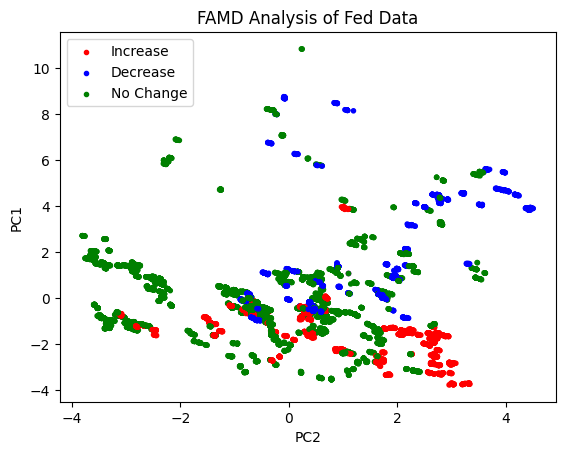

In [9]:
# We now visualize the whole dataset in 2D
plt.scatter(X_famd[:][1], X_famd[:][0], marker='.', c=y.astype(float), cmap=custom_cmap)
plt.title('FAMD Analysis of Fed Data')
plt.xlabel('PC2')
plt.ylabel('PC1')

plt.scatter(X_famd[0][1], X_famd[0][0], label="Increase", color='r', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="Decrease", color='b', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="No Change", color='g', marker='.')
plt.legend(loc='upper left')
plt.show()

We see the data is very noisy, but does follow noticable patterns. The colors as shown in the colorbar. 

### Learning Algorithms and In-Depth Analysis

Our primary, naive attempt was to do a XGBoost regression. Accommodating to continuous data required we split our training and testing sets on a specific date. However, as seen below, this failed to properly model the changes.

IMAGE


Recognizing that predicting the exact interest rate would be difficult, we decided classifying an increase, decrease, or no change in the rate rather than regression was a better approach. For our classification problem, we employ the ensamble algorithms XGBoost and Random Forests, as well as other other methods SoftMax Logistic Regression and GDA.

Since the beginning of our data, there have been 275 scheduled FOMC decisions. With this limited selection of data, we use Stratified 5-Fold Cross Validation for testing our model, averaging the score across each group. To optimally tune the hyperparameters, we utilize the library `Bayesian Optimization`, which uses bayesian inference and gaussian processes to optimally iterate through hyperparameters. See the appendix for our implementation of this code. After tuning hyperparameters, we test each model, using KFold validation in the cell below:


In [13]:
def categorical(df, col_split):
    """
    Prepares the data for the model by standardizing the continuous features, 
    converting the categorical features to strings, 
    and converting sparse columns to a dense format for FAMD.
    """
    categorical_cols = df.columns[:col_split]

    # converting the categorical features to strings
    df[categorical_cols] = df[categorical_cols].astype(str)

    return df

def load_data(data_address='beta_dates/beta_data_2_42.csv', label_address='beta_dates/true_labels.csv'):
    """
    Loads the data and labels from the specified addresses.
    """
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0).values[:,0]
    # add one to the labels to make them 0, 1, 2 instead of -1, 0, 1 (needed for XGBClassifier)
    y = y + 1
    X = categorical(df, 4)

    return X, y

# Function to perform cross-validation and return average accuracy and classification report
def evaluate_model(pipe, X, y, params, n_splits=5):
    """
    Performs cross-validation on the given model and returns the average accuracy and classification report.
    """
    pipe.set_params(**params)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    accuracy_scores = []
    all_predictions = []
    all_true_values = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pipe.fit(X_train, y_train)
        predictions = pipe.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, predictions))
        all_predictions.extend(predictions)
        all_true_values.extend(y_test)

    report = classification_report(all_true_values, all_predictions, zero_division=0)
    return np.mean(accuracy_scores), report

# Load your data
X, y = load_data()

# Apply FAMD for dimensionality reduction
famd = FAMD(n_components=6)
famd.fit(X)
X_transformed = famd.transform(X)

# Evaluate RandomForestClassifier
rf_params = {'rf__max_depth': 4, 'rf__max_features': 0.65, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 17, 'rf__n_estimators': 200}
avg_rf_accuracy, rf_report = evaluate_model(Pipeline([('rf', RandomForestClassifier())]), X_transformed, y, rf_params)


# Evaluate XGBClassifier
xgb_params = {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 3.646092407548312, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__min_child_weight': 9.488817186497869, 'xgb__n_estimators': 81, 'xgb__reg_alpha': 1.5988455864986395, 'xgb__reg_lambda': 3.267653422896763, 'xgb__subsample': 1.0}
avg_xgb_accuracy, xgb_report = evaluate_model(Pipeline([('xgb', XGBClassifier(objective='multi:softmax'))]), X_transformed, y, xgb_params)


# Evaluate Softmax Logistic Regression
avg_lr_accuracy, lr_report = evaluate_model(Pipeline([('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs'))]), X_transformed, y, params={})


# Evaluate GDA
avg_gda_accuracy, gda_report = evaluate_model(Pipeline([('gda', QuadraticDiscriminantAnalysis())]), X_transformed, y, params={})

print('Average Accuracy Results:')
print('RandomForestClassifier - Average Accuracy:', avg_rf_accuracy)
print('XGBClassifier - Average Accuracy:', avg_xgb_accuracy)
print('Softmax Logistic Regression - Average Accuracy:', avg_lr_accuracy)
print('GDA - Average Accuracy:', avg_gda_accuracy)

print('\nClassification Reports:')
print('RandomForestClassifier - Classification Report:\n', rf_report)
print('XGBClassifier - Classification Report:\n', xgb_report)
print('Softmax Logistic Regression - Classification Report:\n', lr_report)
print('GDA - Classification Report:\n', gda_report)

Average Accuracy Results:
RandomForestClassifier - Average Accuracy: 0.8066666666666666
XGBClassifier - Average Accuracy: 0.7919191919191919
Softmax Logistic Regression - Average Accuracy: 0.7516498316498317
GDA - Average Accuracy: 0.6750168350168351

Classification Reports:
RandomForestClassifier - Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.42      0.56        33
         1.0       0.80      0.96      0.87       188
         2.0       0.87      0.49      0.63        53

    accuracy                           0.81       274
   macro avg       0.83      0.63      0.69       274
weighted avg       0.81      0.81      0.79       274

XGBClassifier - Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.39      0.52        33
         1.0       0.78      0.96      0.86       188
         2.0       0.88      0.43      0.58        53

    accuracy                        

Interestingly, the Random Forest Classifier emerges as the top-performing model with an average accuracy of approximately 80.67%. This superior performance can be attributed to the inherent strengths of Random Forests in handling many data types, its robustness to overfitting, and its ability to model complex interactions and non-linear relationships. The classification report shows high precision and recall for class 1.0 (no change in interest rate), indicating strong performance in identifying the most prevalent class. However, it's notable that the recall for rate increases and decreases is comparatively lower, suggesting some challenges in correctly classifying the minority classes.

XGBClassifier, with an average accuracy of about 79.19%, is a close second.  The classification report for XGBoost mirrors that of the Random Forest, with a slight decrease in the recall for interest rate increases and decreases. This indicates a similar trend in the models' ability to handle minority classes.

Softmax Logistic Regression shows an average accuracy of around 75.16%. Its linearity likely provides limitations compared to ensemble methods (Random Forest and XGBoost), which might not capture complex economic decision-making scenarios. The classification report reflects a balanced performance across classes, albeit with lower precision and recall values than the ensemble methods, especially for the minority classes.

Gaussian Discriminant Analysis exhibits the lowest average accuracy at approximately 67.50%. GDA makes assumptions about the distribution of data (i.e., Gaussian), which likely does not hold true for our dataset, possibly leading to its lower performance. Interestingly, the classification report shows a relatively higher recall for the minority classes compared to the other models, indicating its potential in identifying these classes, albeit at the cost of precision.

Returning to the fundamental questions of our project:
What regression and classification methods are best suited to forecasting FOMC decisions?

: Among the methods analyzed, the RandomForestClassifier is best suited for forecasting these decisions. Its ability to handle complex data structures and its robustness against overfitting make it the most effective choice for this classification task.

How accurately can we predict FOMC decisions?
The RandomForestClassifier, as the most effective model in our analysis, predicts FOMC decisions with an average accuracy of approximately 80.67%. This level of accuracy indicates a high degree of reliability in the model's predictions. However, it's important to note that while this accuracy is notable, there remains a degree of uncertainty, particularly in predicting less frequent decision outcomes. Therefore, while predictions are generally reliable, they should be contextualized within the inherent unpredictability of FOMC decisions.

Return


Learning Algorithms and In-depth Analysis (15 points): Analyze the data using the techniques discussed in class. Explain what research questions you can answer using the techniques presented this semester.

Be able to explain the results of your analysis, whether the results are meaningful, and why you chose the tools that you used.  

Important note: It is more important to use the statistical and machine learning tools thoughtfully,  correctly, and honestly than it is to "get the result" that you hoped for.  If there is no evidence of an effect, there is no shame in that, but you must honestly admit it and show the careful work that led you to that conclusion.  If the algorithms cannot predict what you wanted them to predict, be honest about that.  The worst thing to do would be to try to make your results look stronger than they really are by doing sloppy work, by omitting important analysis, data, or plots, or by falsifying data or results. 

### Ethical Implications

We have attempted to develop a model for predicting changes in the federal funds rate based on available economic indicators. As mentioned previously, the ability to predict changes to this prevailing interest rate before FOMC announcement allows for making strategical decisions to minimize or eliminate losses. For example, a prior prediction of what will happen to interest rates might motivate an individual to move from a low-security job to a high-security job, choose to wait or to rush to get a loan, or sell and buy stocks prior to a big move in the stock market.

Our intent and methodology raise a number of ethical issues. First, attempting to obtain an advantage through  information about the future inherently leads to others who do not share that information facing a disadvantage. For example, someone who has highly credible evidence to believe that the Federal Reserve will decrease the federal funds rate has incentive to sell stocks while keeping this information private so that others do not push the stock price down. Yet by not sharing that evidence, such an individual puts other investors in a more difficult place. Such moral grounds are the basis for material nonpublic information laws that prohibit using, sharing, or selling information about future company decisions that will affect stock prices to turn a profit (#A). While the information obtained through analysis such as that performed in this portfolio is not nearly as certain or exclusive (as the work we have done is highly reproducible), it is still important to acknowledge that successful attempts to predict the market in order to profit will inevitably result in someone losing in a zero-sum, competitive financial world.

Another ethical consideration is the potential loss that could be incurred when too much trust is placed in the prediction of the change in the federal fund rate generated by a model such as ours. With so many factors being weighed and considered by the Federal Reserve, and with economic indicators being so numerous and complex, it is inconceivable that any model used to predict changes in the federal funds rate could have near-perfect accuracy. Those that do not understand the extreme uncertainty involved in both the inputs and outputs to the model are likely to pivot too far, opening themselves up to loss incurred when the actual Federal Reserve decision flies in the face of predictions. In making and sharing predictions, therefore, it is important that equal emphasis and care is placed to express the uncertainty of the outcome, as well as to acknowledge that despite warnings, many will take risks based on the predictions that may have severe economic consequences.

Finally, it is important to note that our aim and methodology of predicting economic outcomes, when implemented and replicated on a large scale, may actually influence the outcomes themselves. Several times throughout history, the mere expectation of economic outcomes or a lack of faith in economic indicators have created economic disasters. For instance, in the events of Black Monday on October 19, 1987, the Dow Jones Industrial Average fell twenty percent in one day. The initial trigger was nervousness about possible overvaluation of stocks and the decline of the dollar, but the crisis was intensified by panic due to a lack of information as to what was happening ("B"). This episode and many others demonstrate that expectations or predictions of what will happen, whether grounded or totally unfounded, can often become a self-fulfilling prophecy. Thus it is possible that initially spurious relationships between economic indicators and interest rates mistakenly included or even emphasized in a model like this one might actually generate an unintended (and perhaps undesired) causal relationship, especially when machine learning is involved. Thus care must be taken to critically analyze how features are included, removed, or split on in such models, especially when destructive self-fulfilling feedback loops can have dramatic financial effects on millions across the country.  

### Citations:
A. https://www.investopedia.com/terms/m/materialinsiderinformation.asp

B. https://en.wikipedia.org/wiki/Black_Monday_(1987)

### Appendix

The appendix contains both our code to pull the data pull and code to clean the data.

In [11]:
### Data Pulls

# specify what data to pull from FRED
fred = fd.Fred(api_key = 'bde7928ce1d3cc555b5d2fb725f0ef4b')
start_dt = '1/1/1989'
name_id = [('loan', 'PRIME'), ('exports', 'A020RL1Q158SBEA'), ('pce', 'PCETRIM12M159SFRBDAL'),
           ('ue', 'UNRATE'), ('rgdp', 'A191RL1Q225SBEA'), ('cars', 'TOTALSA'), ('recess', 'USREC'),
           ('gdpd', 'A191RI1Q225SBEA'), ('veloc', 'M1V'), ('house', 'HOUST'), ('mich', 'MICH')]
fred_data = []

for x in name_id:
    # get FRED series using the proper id
    df = pd.DataFrame(fred.get_series(x[1], observation_start=start_dt))
    # make column name identifiable
    df.rename(columns={0: x[0]}, inplace=True)
    fred_data.append(df)

# aggregate FRED data series
df_fred = pd.concat(fred_data, axis=1)

# specify what data to pull from Yahoo! Finance
tickers = [('spx', '^SPX'), ('usd', 'DX-Y.NYB')]
start_dt = '1989-01-01'
end_dt = str(date.today() - timedelta(1))
interval = '1d'
stock_data = []

# access data and display
for t in tickers:
    # get price data using ticker
    df = yf.download(t[1], start = start_dt, end = end_dt, interval= interval)
    # make column name identifiable
    df = df[['Adj Close']].rename(columns={'Adj Close': t[0]})
    stock_data.append(df)

# aggregate stock data
df_stock = pd.concat(stock_data, axis=1)

# read in cli data from csv file downloaded off OECD website
df_cli = pd.read_csv('cli.csv', index_col=0)
df_cli.index = pd.to_datetime(df_cli.index)

# read in manually gathered political party data
df_party = pd.read_csv('party.csv', index_col=0)
df_party.index = pd.to_datetime(df_party.index)

# create feature dataset
df_features = pd.concat([df_fred, df_stock, df_cli, df_party], axis=1)

# pull in FOMC data 
df_fomc = pd.read_csv('ffr_clean.csv', index_col=0)
df_fomc.index = pd.to_datetime(df_fomc.index)

# create decisions and momentum column
decision = df_fomc['change'].values.copy()
down, up = tuple([decision < 0]), tuple([decision > 0])
decision[down], decision[up] = -1., 1.

# create new columns
df_fomc['decision'] = decision
df_fomc['mom'] = decision

# consider only scheduled meetings
df_fomc = df_fomc.query('scheduled == 1')
df_fomc.drop('scheduled', axis=1, inplace=True)

# get start and end dates
start_dt = df_features.index[0]
end_dt = df_fomc.index[-1]

# get every day between start and end date
delta = end_dt - start_dt
daily = [start_dt + timedelta(days=i) for i in range(delta.days + 1)]

# make dataframe of dates
df_days = pd.DataFrame(daily)
df_days.index = pd.to_datetime(df_days.values[:,0])

# initialize master dataframe
df = pd.concat([df_days, df_fomc, df_features], axis=1)

# drop irrelevant columns and rows
df.drop(0, axis=1, inplace=True)
last_ix = df_days.index.get_loc(end_dt) + 1
df.drop(df.index[last_ix:], inplace=True)

# find start and stop columns
cols = df.columns.to_list()
start_ix, end_ix = cols.index('mom'), cols.index('fed_party')

# shift necessary columns
df_shift = df.iloc[:, start_ix:end_ix].copy()
df.iloc[:, start_ix:end_ix] = df_shift.shift()

# fill in NaN entries
df_fill = df.iloc[:, start_ix:].copy()
df.iloc[:, start_ix:] = df_fill.ffill()

# save master dataframe
df.to_csv('master_data.csv')
df.tail()

In [ ]:
### Data Cleaning

# define the columns
monthly = ['pce','ue','cars','house','cli','exports','rgdp','gdpd','veloc', 'ffr','mich']
labels = ['decision', 'ffr', 'change']
daily = ['spx','usd', 'loan']
categorical = ['fed_party','potus_party','recess', 'mom']

# define the function to collapse the data to the event days
def collapse(df, key = 'label_day', start = 7, end = 60, cat_col = [], daily_col = [], other = [], labels = []):
    """A function to collapse the data into a single row for each event, capturing trends and point in time data.
    df: dataframe
    key: column name of the event day
    start: number of days before the event to capture
    end: number of days after the event to capture"""
    
    # Get our different dataframes
    categorical = df[cat_col]
    daily = df[daily_col]
    monthly = df[other]
    keep = df[key]
    labels = df[labels]

    # create the windows
    event_days = df[df[key]].index

    ################## Handle Categorical and Label Data ##################
    cat_collapsed = categorical[keep]
    y_labels = labels[keep]

    ################## Handle Monthly Data ##################
    # Create event windows
    windows = []
    for day in event_days:
        # Calculate start and end days of the window
        start_day = day - pd.Timedelta(days=start)
        end_day = day - pd.Timedelta(days=end)

        # Ensure start_day is not before the start of the dataset
        if end_day < df.index[0]:
            end_day = df.index[0]

        windows.append((start_day, end_day))

    # Initialize a list to store aggregated data
    aggregated_data = []

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = monthly.loc[end_day:start_day]

        # Apply your custom aggregation function
        final_vals = window_data.loc[start_day]
        change = final_vals - window_data.iloc[0]
        # relabel the change columns to include a d_ prefix
        change = change.rename(lambda x: 'd_' + x)

        # concatenate the data horizontally
        aggregated_window = pd.concat([final_vals, change], axis=0)
        aggregated_data.append(aggregated_window)

    # Combine aggregated data
    aggregated_monthly = pd.concat(aggregated_data, axis=1).T
    aggregated_monthly.index = event_days

    ################## Handle Daily Data ##################
    # define the model
    model = linear_model.LinearRegression()
    daily_agg = []

    # Get the names of the features
    daily_feat = daily.columns
    b0_name = ['b0_' + feat for feat in daily_feat]
    b1_name = ['b1_' + feat for feat in daily_feat]

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = daily.loc[end_day:start_day]
        time = np.arange(len(window_data)).reshape(-1, 1)

        # Initialize lists to store betas for each feature
        beta0 = []
        beta1 = []

        # Loop through each feature and fit the model
        for feat in daily_feat:
            model.fit(time, window_data[feat])
            beta0.append(model.intercept_)
            beta1.append(model.coef_[0])

        # Create DataFrames for betas
        beta0_df = pd.DataFrame([beta0], columns=b0_name)
        beta1_df = pd.DataFrame([beta1], columns=b1_name)

        # concatenate the data horizontally
        aggregated_window = pd.concat([beta0_df, beta1_df], axis=1)
        daily_agg.append(aggregated_window)

    # Combine aggregated data
    aggregated_daily = pd.concat(daily_agg, axis=0)
    aggregated_daily.index = event_days

    ################## Combine Data ##################
    # Combine all data
    combined = pd.concat([cat_collapsed, aggregated_monthly, aggregated_daily], axis=1)
    return combined, y_labels

In [24]:
# Load your dataset
X, y = load_data()

# Apply FAMD for dimensionality reduction
famd = FAMD(n_components=13)
famd.fit(X)
X_transformed = famd.transform(X)

# Create a pipeline with Random Forest
pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# Function to optimize with cross-validation
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'rf__n_estimators': int(n_estimators),
        'rf__max_depth': int(max_depth),
        'rf__min_samples_split': int(min_samples_split),
        'rf__min_samples_leaf': int(min_samples_leaf),
        'rf__max_features': max_features,
    }
    pipe.set_params(**params)
    return np.mean(cross_val_score(pipe, X_transformed, y, cv=5, scoring='accuracy'))

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds={
        'n_estimators': (50, 300),
        'max_depth': (3, 5),
        'min_samples_split': (2, 30),
        'min_samples_leaf': (1, 30),
        'max_features': (0.1, 1)
    },
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=200)

# After optimization, retrieve and adjust best parameters for pipeline
rf_best_params = optimizer.max['params']
rf_best_params_for_pipeline = {'rf__' + key: int(value) if key in ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf'] else value for key, value in rf_best_params.items()}

# Set the best parameters in the pipeline
pipe.set_params(**rf_best_params_for_pipeline)
pipe.fit(X_transformed, y)

# Print best parameters and performance
print("Best Parameters for Pipeline:", rf_best_params_for_pipeline)
print("Best Performance:", optimizer.max['target'])

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.6818    | 3.749     | 0.9556    | 22.23     | 18.76     | 89.0      |
| 2         | 0.6861    | 3.312     | 0.1523    | 26.12     | 18.83     | 227.0     |
| 3         | 0.6636    | 3.041     | 0.9729    | 25.14     | 7.945     | 95.46     |
| 4         | 0.7301    | 3.367     | 0.3738    | 16.22     | 14.09     | 122.8     |
| 5         | 0.6783    | 4.224     | 0.2255    | 9.472     | 12.26     | 164.0     |
| 6         | 0.7185    | 3.173     | 0.5258    | 12.47     | 19.02     | 126.9     |
| 7         | 0.6861    | 4.713     | 0.1       | 22.98     | 8.646     | 130.7     |
| 8         | 0.7078    | 3.0       | 0.4375    | 10.62     | 15.25     | 117.9     |
| 9         | 0.693     | 3.0       | 0.9759    | 19.84     | 19.97     | 121.3     |
| 10        | 0.7077    | 3.807     | 0.4976    | 12.7

In [25]:
# Load your dataset
X, y = load_data()

# Apply FAMD for dimensionality reduction
famd = FAMD(n_components=13)
famd.fit(X)
X_transformed = famd.transform(X)

# Create a pipeline with XGBoost
pipe = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softprob'))  # Using multi:softprob for multi-class classification
])

# Function to optimize with cross-validation
def xgb_evaluate(n_estimators, max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        'xgb__n_estimators': int(n_estimators),
        'xgb__max_depth': int(max_depth),
        'xgb__learning_rate': learning_rate,
        'xgb__gamma': gamma,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_alpha': reg_alpha,
        'xgb__reg_lambda': reg_lambda
    }
    pipe.set_params(**params)
    return np.mean(cross_val_score(pipe, X_transformed, y, cv=5, scoring='accuracy'))

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'n_estimators': (50, 300),
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'gamma': (0, 5),
        'min_child_weight': (1, 10),
        'subsample': (0.5, 1),
        'colsample_bytree': (0.5, 1),
        'reg_alpha': (0, 5),
        'reg_lambda': (0, 5)
    },
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=200)

# After optimization, retrieve and adjust best parameters for pipeline
xgb_best_params = optimizer.max['params']
xgb_best_params_for_pipeline = {'xgb__' + key: int(value) if key in ['n_estimators', 'max_depth'] else value for key, value in xgb_best_params.items()}

# Set the best parameters in the pipeline
pipe.set_params(**xgb_best_params_for_pipeline)
pipe.fit(X_transformed, y)

# Print best parameters and performance
print("Best Parameters for Pipeline:", xgb_best_params_for_pipeline)
print("Best Performance:", optimizer.max['target'])

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7039    | 0.6873    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.2904    | 4.331     | 0.8006    |
| 2         | 0.5869    | 0.854     | 0.1029    | 0.2913    | 8.827     | 2.911     | 95.46     | 0.917     | 1.521     | 0.7624    |
| 3         | 0.7294    | 0.716     | 1.456     | 0.1874    | 3.976     | 3.629     | 141.6     | 2.28      | 3.926     | 0.5998    |
| 4         | 0.7339    | 0.7571    | 2.962     | 0.02347   | 7.253     | 2.535     | 66.26     | 4.744     | 4.828     | 0.9042    |
| 5         | 0.5831    | 0.6523    | 0.4884    | 0.2084    | 6.081     | 2.098     | 173.8     | 0.1719    | 4.547     | 0.6294    |
| 6         | 0.73      | 0.9804    | 3.013     | 0.2973    | 